# 뉴스 카테고리 다중분류
---

뉴스 데이터의 카테고리를 분류하는 분류기를 생성하고 이들의 성능을 비교하여 보자.
1. 머신러닝 분류기 뿐만 아니라 딥러닝 분류기를 정의하고 사용해보자.
2. 데이터를 전처리에는 TF-IDF를 사용하고, 단어사전의 수에 따른 성능 창리를 확인해보자.

## Step 0. 설계
---

1. 데이터 불러오기
    - 로이터 뉴스 데이터를 불어들인다.
    - 이때, 단어사전의 수가 제한없음, 5000, 10000이 되는 세가지의 데이터셋을 구성한다.
    - 불러들인 데이터를 TF-IDF 방식으로 벡터화한다.
2. 머신러닝 분류기를 통한 다중분류
    - 아래의 8가지 머신러신 분류기를 학습시키는 함수를 작성한다.
         - 나이브 베이지안 분류기
        - 컴플리트 나이브 베이즈 분류기
        - 로지스틱 회귀
        - 선형 서포트 벡터 머신
        - 결정트리
        - 랜덤 포레스트
        - 그래디언트 부스팅 트리
        - 보팅 : 로지스틱 회귀 + 컴플리트 나이브 베이즈 분류기 + 그래디언트 부스팅 트리
    - 각 분류기를 학습 시키고 단어 사전의 크기에 따른 성능과 각 분류기에 따른 성능을 비교하여 본다.
3. 딥러닝 분류기를 통한 다중분류
    - 다중분류를 위한 딥러닝 모델을 설계한다.
    - 모델을 학습시키고 단어 사전의 크기에 따른 성능을 비교하여 본다.
    - 머닝러닝 분류기와 딥러닝 분류기의 성능을 비교하여 본다.

#### environment setting

In [68]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [69]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




## Step 1. 데이터 불러오기
---

### 1. 데이터 로더 구성

데이터 로더의 역할을 아래와 같다.
1. 입력받은 단어사전 수에 맞게 로이터 뉴스 데이터를 읽어들인다.
2. 위에서 읽어들인 데이터의 디코딩하여 문장 데이터를 복원한다.
3. 2에서 복원한 데이터를 TF-IDF 방식으로 벡터화 한다.
4. 1에서 읽어들인 데이터의 target을 one-hot vecotr 방식으로 벡터화 한다.
5. X_train, X_train_tfidfv, y_train, y_train_ct, X_test, X_test_tfidfv, y_test, y_test_ct를 반환한다.
    - X_train : 2의 결과, 디코딩된 영어기사 문장
    - X_train_tfidfv : 3의 결과, TF-IDF
    - y_trian : target, single int
    - y_train_ct  3의 결과,: taget, catecorical label

In [70]:
class Dataset:
    def __init__(self, num_words):
        (self.X_train_tfidfv, self.X_train, self.y_train, self.y_train_ct,
         self.X_test_tfidfv, self.X_test, self.y_test, self.y_test_ct) = self.load_data(num_words=num_words)
    
    @classmethod
    def load_data(cls, num_words=10000):
        (x_train, y_train), (x_test, y_test) = train, test = reuters.load_data(num_words=num_words, test_split=0.2)

        word_index = reuters.get_word_index(path="reuters_word_index.json")
        index_word = {i + 3 : w for w, i in word_index.items()}
        for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
            index_word[index]=token

        x_train = [ ' '.join([index_word[i] for i in sen]) for sen in x_train ]
        x_test = [ ' '.join([index_word[i] for i in sen]) for sen in x_test ]

        dtmvector = CountVectorizer()
        tfidf_transformer = TfidfTransformer()

        x_train_dtm = dtmvector.fit_transform(x_train)
        x_train_tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
        
        x_train_dtm = dtmvector.transform(x_train)
        x_train_tfidfv = tfidf_transformer.transform(x_train_dtm)

        x_test_dtm = dtmvector.transform(x_test)
        x_test_tfidfv = tfidf_transformer.transform(x_test_dtm)
        
        class_num = max(y_train) + 1
        y_train_ct = tf.keras.utils.to_categorical(y_train, class_num)
        y_test_ct = tf.keras.utils.to_categorical(y_test, class_num)

        return x_train_tfidfv, x_train, y_train, y_train_ct, x_test_tfidfv, x_test, y_test, y_test_ct

### 2. 데이터 불러오기

#### 1) vocab size = None, 모든 단어 사용

In [78]:
dataset_all = Dataset(None)
print(dataset_all.X_train_tfidfv.shape, dataset_all.X_test_tfidfv.shape)

(8982, 26506) (2246, 26506)


In [72]:
dataset_all.X_train[4587]

'<sos> shr 1 86 dlrs vs 1 85 dlrs net 1 923 304 vs 1 897 998 reuter 3'

In [73]:
vocab_size = len(reuters.get_word_index(path="reuters_word_index.json")) + 3

#### 2) vocab size = 5000, 빈도수 상위 5,000개의 단어만 사용

In [74]:
dataset_5000 = Dataset(5000)
print(dataset_5000.X_train_tfidfv.shape, dataset_5000.X_test_tfidfv.shape)

(8982, 4867) (2246, 4867)


In [75]:
dataset_5000.X_train[4587]

'<sos> shr 1 86 dlrs vs 1 85 dlrs net 1 <unk> 304 vs 1 <unk> <unk> reuter 3'

#### 3) vocab size = 10000, 빈도수 상위 10,000개의 단어만 사용

In [76]:
dataset_10000 = Dataset(10000)
print(dataset_10000.X_train_tfidfv.shape, dataset_10000.X_test_tfidfv.shape)

(8982, 9670) (2246, 9670)


In [77]:
dataset_10000.X_train[4587]

'<sos> shr 1 86 dlrs vs 1 85 dlrs net 1 <unk> 304 vs 1 897 998 reuter 3'

## Step 2. 머신러닝 분류기를 통한 다중분류
---

### 1. 머신러닝 분류기 학습 함수 작성
아래의 8가지 머신러신 분류기를 학습시킨 후 평가(accuarcy, f1 score) 결과를 반화하는 함수를 작성한다.
- 나이브 베이지안 분류기
- 컴플리트 나이브 베이즈 분류기
- 로지스틱 회귀
- 선형 서포트 벡터 머신
- 결정트리
- 랜덤 포레스트
- 그래디언트 부스팅 트리
- 보팅 : 로지스틱 회귀 + 컴플리트 나이브 베이즈 분류기 + 그래디언트 부스팅 트리

In [80]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import time
import pandas as pd

In [11]:
def train_and_evaluate(Model, parms, dataset, verbose=1):
    begin = time.time()
    
    model = Model(**parms)
    model.fit(dataset.X_train_tfidfv, dataset.y_train)
    predicted = model.predict(dataset.X_test_tfidfv)
    
    acc = accuracy_score(dataset.y_test, predicted)
    f1 = f1_score(dataset.y_test, predicted, average='weighted')

    end = time.time()
    
    if verbose > 0:
        print(f"[{Model.__name__}] done")
    
    if verbose > 1:
        print(f"Processing time: {(end - begin)} sec")
        print(f"accuracy : {acc}")
        print(f"f1 score : {f1}\n")
        
    return acc, f1

In [12]:
def run_train_and_evalute(classifiers, dataset, verbose=1):
    res = [ ]
    for classifier, params in classifiers:
        acc, f1 = train_and_evaluate(classifier, params, dataset, verbose)
        res.append({'acc': acc, 
                    'f1': f1})
    return res

In [79]:
classifiers = [
    (MultinomialNB, {}), # 나이브 베이지안 분류기
    (ComplementNB, {}),  # 컴플리트 나이브 베이즈 분류기
    (LogisticRegression, { 'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2500}), # 로지스틱 회귀
    (LinearSVC, {'C': 1000, 'penalty': 'l1', 'max_iter': 2500, 'dual': False}), # 선형 서포트 벡터 머신
    (DecisionTreeClassifier, {'max_depth': 10, 'random_state': 0}), # 결정트리
    (RandomForestClassifier, {'n_estimators': 5, 'random_state': 0}), # 랜덤 포레스트
    (GradientBoostingClassifier, {'random_state': 0}), # 그래디언트 부스팅 트리
    (VotingClassifier, {'estimators':[
                         ('lr', LogisticRegression(C=10000, penalty='l2', max_iter=2500)),
                         ('cb', ComplementNB()),
                         ('grbt', GradientBoostingClassifier(random_state=0))], 
                        'voting':'soft',
                        'n_jobs':-1 }), # 보팅
]

classifier_names = [ 'MultinomialNB',
                     'ComplementNB',
                     'LogisticRegression',
                     'LinearSVC',
                     'DecisionTreeClassifier',
                     'RandomForestClassifier',
                     'GradientBoostingClassifier',
                     'VotingClassifier']

### 2. 모델 학습 및 평가

#### 1) vocab size = None

In [19]:
res = run_train_and_evalute(classifiers, dataset_all, verbose=2)
train_res_all = pd.DataFrame(res, index=classifier_names)
train_res_all

[MultinomialNB] done
Processing time: 0.05890989303588867 sec
accuracy : 0.5997328584149599
f1 score : 0.5045670886188423

[ComplementNB] done
Processing time: 0.07724595069885254 sec
accuracy : 0.7649154051647373
f1 score : 0.7346534179503126

[LogisticRegression] done
Processing time: 624.3164720535278 sec
accuracy : 0.8165627782724845
f1 score : 0.8111268305241908



/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LinearSVC] done
Processing time: 84.65297222137451 sec
accuracy : 0.7920747996438112
f1 score : 0.7877334430669888

[DecisionTreeClassifier] done
Processing time: 1.4907686710357666 sec
accuracy : 0.6211041852181657
f1 score : 0.5769283128518846

[RandomForestClassifier] done
Processing time: 2.4329726696014404 sec
accuracy : 0.6544968833481746
f1 score : 0.6225909375608356

[GradientBoostingClassifier] done
Processing time: 872.2949137687683 sec
accuracy : 0.7702582368655387
f1 score : 0.7641672650539437

[VotingClassifier] done
Processing time: 936.0385172367096 sec
accuracy : 0.8156723063223509
f1 score : 0.8117561034163696



,acc,f1
MultinomialNB,0.599733,0.504567
ComplementNB,0.764915,0.734653
LogisticRegression,0.816563,0.811127
LinearSVC,0.792075,0.787733
DecisionTreeClassifier,0.621104,0.576928
RandomForestClassifier,0.654497,0.622591
GradientBoostingClassifier,0.770258,0.764167
VotingClassifier,0.815672,0.811756


#### 2) vocab size = 5000

In [20]:
res = run_train_and_evalute(classifiers, dataset_5000, verbose=1)
train_res_5000 = pd.DataFrame(res, index=classifier_names)
train_res_5000

[MultinomialNB] done
[ComplementNB] done
[LogisticRegression] done


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LinearSVC] done
[DecisionTreeClassifier] done
[RandomForestClassifier] done
[GradientBoostingClassifier] done
[VotingClassifier] done


,acc,f1
MultinomialNB,0.673197,0.601250
ComplementNB,0.770703,0.745899
LogisticRegression,0.802760,0.797480
LinearSVC,0.772484,0.770837
DecisionTreeClassifier,0.617988,0.572997
RandomForestClassifier,0.701247,0.677022
GradientBoostingClassifier,0.767587,0.766248
VotingClassifier,0.810329,0.807593


#### 3) vocab size = 10000

In [21]:
res = run_train_and_evalute(classifiers, dataset_10000, verbose=1)
train_res_10000 = pd.DataFrame(res, index=classifier_names)
train_res_10000

[MultinomialNB] done
[ComplementNB] done
[LogisticRegression] done


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LinearSVC] done
[DecisionTreeClassifier] done
[RandomForestClassifier] done
[GradientBoostingClassifier] done
[VotingClassifier] done


,acc,f1
MultinomialNB,0.656723,0.576447
ComplementNB,0.770703,0.745668
LogisticRegression,0.810775,0.805657
LinearSVC,0.786732,0.781952
DecisionTreeClassifier,0.620214,0.577640
RandomForestClassifier,0.674087,0.642948
GradientBoostingClassifier,0.766696,0.762599
VotingClassifier,0.816563,0.813372


#### 4) 평가

- 단어 사전 크기에 따른 성능 차이

In [44]:
data_group_by_classifier = { key: { 'acc': [], 'f1': []}
                             for key in classifier_names }

In [45]:
def append_data(group, res, vocab_size):
    for i, row in res.iterrows():
        group[i]['acc'].append(row['acc'])
        group[i]['f1'].append(row['f1'])
    return group

In [46]:
data_group_by_classifier = append_data(data_group_by_classifier, train_res_all, 'all')
data_group_by_classifier = append_data(data_group_by_classifier, train_res_5000, '5000')
data_group_by_classifier = append_data(data_group_by_classifier, train_res_10000, '10000')
data_group_by_classifier

{'MultinomialNB': {'acc': [0.599733, 0.673197, 0.656723],
  'f1': [0.504567, 0.60125, 0.576447]},
 'ComplementNB': {'acc': [0.764915, 0.770703, 0.770703],
  'f1': [0.734653, 0.745899, 0.745668]},
 'LogisticRegression': {'acc': [0.816563, 0.80276, 0.810775],
  'f1': [0.811127, 0.79748, 0.805657]},
 'LinearSVC': {'acc': [0.792075, 0.772484, 0.786732],
  'f1': [0.787733, 0.770837, 0.781952]},
 'DecisionTreeClassifier': {'acc': [0.621104, 0.617988, 0.620214],
  'f1': [0.576928, 0.572997, 0.57764]},
 'RandomForestClassifier': {'acc': [0.654497, 0.701247, 0.674087],
  'f1': [0.622591, 0.677022, 0.642948]},
 'GradientBoostingClassifier': {'acc': [0.770258, 0.767587, 0.766696],
  'f1': [0.764167, 0.766248, 0.762599]},
 'VotingClassifier': {'acc': [0.815672, 0.810329, 0.816563],
  'f1': [0.811756, 0.807593, 0.813372]}}

In [47]:
df_group_by_classifier = { key: pd.DataFrame(data_group_by_classifier[key], index=['all', '5000', '10000'])
                           for key in classifier_names }
df_group_by_classifier['MultinomialNB']

,acc,f1
all,0.599733,0.504567
5000,0.673197,0.601250
10000,0.656723,0.576447


In [55]:
for idx in classifier_names:
    print(idx)
    display(df_group_by_classifier[idx])

MultinomialNB


,acc,f1
all,0.599733,0.504567
5000,0.673197,0.601250
10000,0.656723,0.576447


ComplementNB


,acc,f1
all,0.764915,0.734653
5000,0.770703,0.745899
10000,0.770703,0.745668


LogisticRegression


,acc,f1
all,0.816563,0.811127
5000,0.802760,0.797480
10000,0.810775,0.805657


LinearSVC


,acc,f1
all,0.792075,0.787733
5000,0.772484,0.770837
10000,0.786732,0.781952


DecisionTreeClassifier


,acc,f1
all,0.621104,0.576928
5000,0.617988,0.572997
10000,0.620214,0.577640


RandomForestClassifier


,acc,f1
all,0.654497,0.622591
5000,0.701247,0.677022
10000,0.674087,0.642948


GradientBoostingClassifier


,acc,f1
all,0.770258,0.764167
5000,0.767587,0.766248
10000,0.766696,0.762599


VotingClassifier


,acc,f1
all,0.815672,0.811756
5000,0.810329,0.807593
10000,0.816563,0.813372


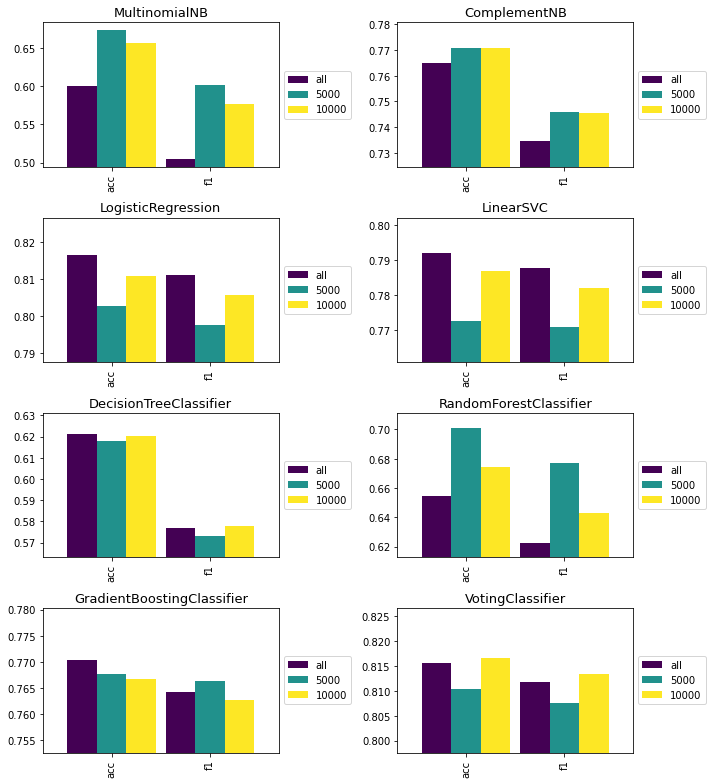

In [256]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(len(df_group_by_classifier)//2, 2, figsize=(10, 11))
axes = [ y for x in axes for y in x ]

for ax, title in zip(axes, classifier_names):
    df_group_by_classifier[title].T.plot(kind='bar', ax=ax, cmap='viridis', width=0.9)
    ax.set_title(title, size=13)
    
    ylim_min = min(min(df_group_by_classifier[title]['acc']),
                   min(df_group_by_classifier[title]['f1']))-0.01
    ylim_max = max(max(df_group_by_classifier[title]['acc']),
                   max(df_group_by_classifier[title]['f1']))+0.01
    ax.set_ylim([ylim_min, ylim_max])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

연예기사를 연예기사로 분류하는 것(recall)과 연예 기사를 정치기사로 분류하지 않는것(precision) 모두 중요한 일이기 때문에 Accuracy 보다 F1 score가 더 중요한 지표라고 할 수 있다. 따라서 평가를 할 때, Accuracy 보다는 F1 score가 더 높은 쪽이 더 성능이 좋다-라고 평가하기로 하자.

각 분류기별로 acc와 f1의 성능이 가장 좋은 vocab 수는 아래와 같다.

| 분류기    |  Accuracy | F1 score |
|:----|:-------:|:---------|
| MultinomialNB  |  5000 |  5000  |
| ComplementNB  | 5000, 100000  |  5000 |
| LogisticRegression  | all | all  |
| LinearSVC  | all  | all  |
| DecisionTreeClassifier  | all  |  10000  |
| RandomForestClassifier  | 5000  | 5000  |
| GradientBoostingClassifier  | all  |  5000  |
| VotingClassifie  | 10000  | 10000  |

위 표에서 5000은 총 7번,  all은 6번, 10000은 4번 등장한다. 그 등장 위치도 더 중점적으로 보기로 하였던, F1 score에서 5000이 압도적으로 자주 등장하는 것을 확일할 수 있다. <br>
따라서 가장 성능이 좋은 단어 사전의 크기는 *<u>5000</u>* 이다.

- 분류기에 따른 성능 차이

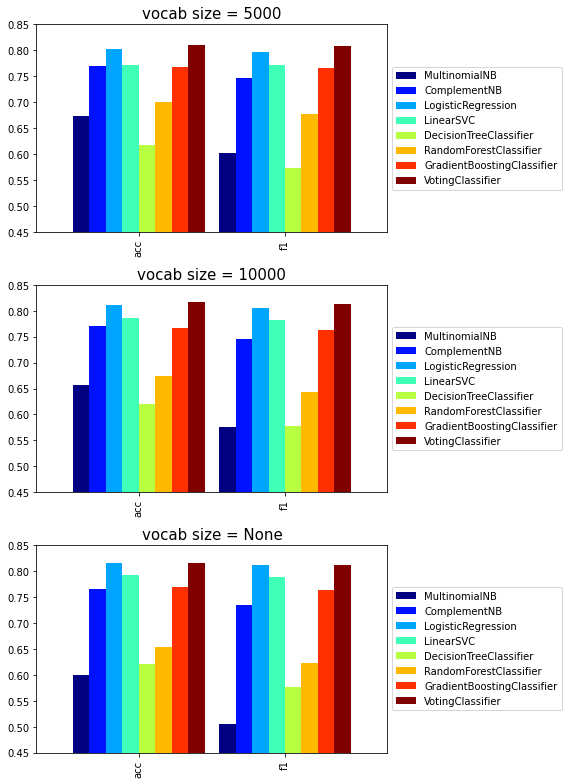

In [249]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(8, 11))
train_res_5000.T.plot(kind='bar', ax=axes[0], cmap='jet', width=0.9)
train_res_10000.T.plot(kind='bar', ax=axes[1], cmap='jet', width=0.9)
train_res_all.T.plot(kind='bar', ax=axes[2], cmap='jet', width=0.9)

titles = ['vocab size = 5000', 'vocab size = 10000', 'vocab size = None']
for ax, title in zip(axes, titles):
    ax.set_title(title, size=15)
    ax.set_ylim([0.45, 0.85])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

모든 vocab size에 대해서 가장 성능이 좋은 분류기는 Voting Classifier이다.

## Step 3. 딥러닝 분류기를 통한 다중분류
---

In [81]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import utils
from keras.preprocessing.text import Tokenizer

### 1. 1D CNN

#### 1) 모델 정의

In [82]:
def get_1d_cnn_model(vocab_size, input_shape, class_num=46):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(512, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(class_num, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [83]:
def get_tf_dataset(dataset, batch_size):
    shape = dataset.X_train_tfidfv.shape
    X_train = dataset.X_train_tfidfv.toarray()
    X_train = X_train.reshape(shape[0], shape[1], 1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                      dataset.y_train_ct,
                                                      test_size=0.1, 
                                                      random_state=50)
    input_shape = (X_train.shape[1], X_train.shape[2])
    dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    return dataset_train, dataset_val, input_shape

- vocab size : 10000

In [18]:
tf_dataset_10000_train, tf_dataset_10000_test, input_shape = get_tf_dataset(dataset_10000, 64)
cnn_10000 = get_1d_cnn_model(10000, input_shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9666, 512)         3072      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 46)                11822     
Total params: 146,222
Trainable params: 146,222
Non-trainable params: 0
_________________________________________________________________


- vocab size : 5000

In [89]:
tf_dataset_5000_train, tf_dataset_5000_test, input_shape_5000 = get_tf_dataset(dataset_5000, 64)
cnn_5000 = get_1d_cnn_model(5000, input_shape_5000)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 4863, 512)         3072      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 46)                11822     
Total params: 146,222
Trainable params: 146,222
Non-trainable params: 0
_________________________________________________________________


#### 2) 모델 학습

In [84]:
def train_with_tf_dataset(model, dataset_train, dataset_val, batch_size=128, epochs=20):
    callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, mode='min', verbose=1)
    history = model.fit(dataset_train,
                        epochs=epochs,
                        validation_data=dataset_val,
                        callbacks=[callback])
    return history.history

In [85]:
def show_history_plot(history):
    targets = [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]
    labels = [['Training loss', 'Validation loss'], ['Training acc', 'Validation acc']]
    titles = ['Training and validation loss','Training and validation accuracy']
    colors = ['b', 'r']
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    for i, ax in enumerate(axes):
        print()
        ax.plot(history[targets[i][0]], colors[i] + 'o', label=labels[i][0])
        ax.plot(history[targets[i][1]], colors[i], label=labels[i][1])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(titles[i])
        ax.legend()
        
    plt.tight_layout()
    plt.show()

- vocab size : 10000

In [75]:
cnn_history_10000 = train_with_tf_dataset(cnn_10000, 
                                          tf_dataset_10000_train, 
                                          tf_dataset_10000_test, 
                                          epochs=100)

Epoch 1/100
127/127 [==============================] - 21s 163ms/step - loss: 2.2847 - accuracy: 0.3788 - val_loss: 2.2979 - val_accuracy: 0.3782
Epoch 2/100
127/127 [==============================] - 22s 173ms/step - loss: 2.2824 - accuracy: 0.3796 - val_loss: 2.2979 - val_accuracy: 0.3815
Epoch 3/100
127/127 [==============================] - 22s 174ms/step - loss: 2.2821 - accuracy: 0.3797 - val_loss: 2.2977 - val_accuracy: 0.3793
Epoch 4/100
127/127 [==============================] - 22s 174ms/step - loss: 2.2816 - accuracy: 0.3801 - val_loss: 2.2974 - val_accuracy: 0.3815
Epoch 5/100
127/127 [==============================] - 22s 173ms/step - loss: 2.2812 - accuracy: 0.3801 - val_loss: 2.2974 - val_accuracy: 0.3815
Epoch 6/100
127/127 [==============================] - 22s 172ms/step - loss: 2.2809 - accuracy: 0.3797 - val_loss: 2.2971 - val_accuracy: 0.3815
Epoch 7/100
127/127 [==============================] - 21s 166ms/step - loss: 2.2808 - accuracy: 0.3799 - val_loss: 2.2967 -

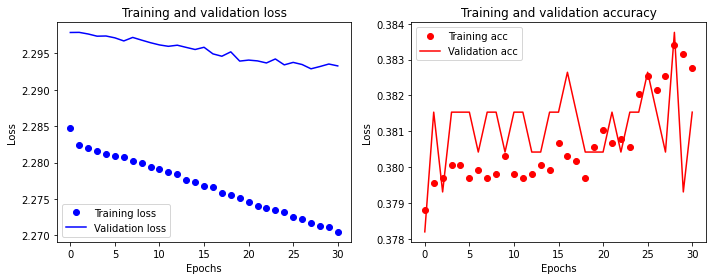

In [258]:
show_history_plot(cnn_history_10000)

- vocab size : 5000

In [90]:
cnn_history_5000 = train_with_tf_dataset(cnn_5000, 
                                         tf_dataset_5000_train, 
                                         tf_dataset_5000_test, 
                                         epochs=100)

Epoch 1/100
127/127 [==============================] - 16s 102ms/step - loss: 2.8860 - accuracy: 0.3452 - val_loss: 2.4109 - val_accuracy: 0.3415
Epoch 2/100
127/127 [==============================] - 9s 73ms/step - loss: 2.4139 - accuracy: 0.3520 - val_loss: 2.4085 - val_accuracy: 0.3415
Epoch 3/100
127/127 [==============================] - 9s 73ms/step - loss: 2.4114 - accuracy: 0.3520 - val_loss: 2.4067 - val_accuracy: 0.3415
Epoch 4/100
127/127 [==============================] - 9s 73ms/step - loss: 2.4095 - accuracy: 0.3520 - val_loss: 2.4046 - val_accuracy: 0.3415
Epoch 5/100
127/127 [==============================] - 9s 73ms/step - loss: 2.4073 - accuracy: 0.3520 - val_loss: 2.4018 - val_accuracy: 0.3415
Epoch 6/100
127/127 [==============================] - 9s 73ms/step - loss: 2.4042 - accuracy: 0.3520 - val_loss: 2.3969 - val_accuracy: 0.3415
Epoch 7/100
127/127 [==============================] - 9s 74ms/step - loss: 2.4001 - accuracy: 0.3523 - val_loss: 2.3913 - val_accurac

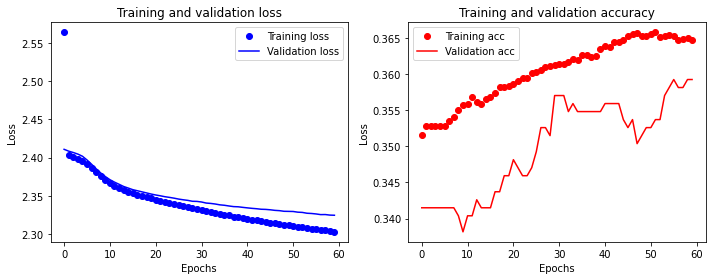

In [92]:
show_history_plot(cnn_history_5000)

#### 3) 모델 평가

머신러닝 분류기와의 성능 비교를 위하여 동일한 matrix(accuary, f1)을 이용하여 평가를 한다.

In [86]:
def evaluate(model, X_test, y_test):
    predicted = [ np.argmax(values) for values in model.predict(X_test) ]
    acc = accuracy_score(y_test, predicted)
    f1 = f1_score(y_test, predicted, average='weighted')

    return acc, f1, predicted

- vocab size : 10000

In [98]:
shape = dataset_10000.X_test_tfidfv.shape
X_test = dataset_10000.X_test_tfidfv.toarray()
X_test = X_test.reshape(shape[0], shape[1], 1)

In [301]:
cnn_acc_10000, cnn_f1_10000, predicted = evaluate(cnn_10000, X_test, dataset_10000.y_test)
cnn_acc_10000, cnn_f1_10000

(0.3748886910062333, 0.26926886272886447)

In [302]:
hist, bins = np.histogram(predicted, range(0, 47))
hist

array([   0,    0,    0, 1817,  237,    0,    0,    0,    0,    0,    0,
         36,    0,    0,    0,    0,   31,    0,    0,  124,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

예측이 어느 정도는 이루어지고 있지만, 그 정확도가 매우 낮다.

- vocab size : 5000

In [94]:
shape = dataset_5000.X_test_tfidfv.shape
X_test = dataset_5000.X_test_tfidfv.toarray()
X_test = X_test.reshape(shape[0], shape[1], 1)

cnn_acc_5000, cnn_f1_5000, predicted_5000 = evaluate(cnn_5000, X_test, dataset_5000.y_test)
cnn_acc_5000, cnn_f1_5000

(0.3717720391807658, 0.23653456351708202)

In [95]:
hist, bins = np.histogram(predicted_5000, range(0, 47))
hist

array([   0,    0,    0, 1965,  121,    0,    0,    0,    0,    0,    0,
         69,    0,    0,    0,    0,    0,    0,    0,   91,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

vocab size가 10000일 때와 비슷하게 예측이 어느 정도는 이루어지고 있지만, 그 정확도가 매우 낮다. 또한 vocab size가 10000일 때에 비하여 더 낮은 수치를 기록하였다.

### 2. LSTM

#### 1) 모델 정의

In [102]:
def get_rnn_model(vocab_size, class_num, input_shape, word_vector_dim=100, units=64):
    rnn_model = tf.keras.Sequential()
    rnn_model.add(tf.keras.layers.Input(shape=(input_shape)))
    rnn_model.add(tf.keras.layers.LSTM(units))
    rnn_model.add(tf.keras.layers.Dense(units, activation='relu'))
    rnn_model.add(tf.keras.layers.Dense(class_num, activation='softmax'))

    rnn_model.summary()
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return rnn_model

In [103]:
def get_tf_dataset(dataset, batch_size):
    shape = dataset.X_train_tfidfv.shape
    X_train = dataset.X_train_tfidfv.toarray()
    X_train = X_train.reshape(shape[0], shape[1], 1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                      dataset.y_train_ct,
                                                      test_size=0.1, 
                                                      random_state=7)
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    return dataset_train, dataset_val, input_shape

- vocab size : 10000

In [112]:
rnn_10000 = get_rnn_model(10000, 46, input_shape, word_vector_dim=100, units=128)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 46)                5934      
Total params: 89,006
Trainable params: 89,006
Non-trainable params: 0
_________________________________________________________________


- vocab size : 5000

In [104]:
rnn_5000 = get_rnn_model(5000, 46, input_shape, word_vector_dim=100, units=128)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 46)                5934      
Total params: 89,006
Trainable params: 89,006
Non-trainable params: 0
_________________________________________________________________


#### 2) 모델 학습

- vocab size : 10000

In [113]:
rnn_history_10000 = train_with_tf_dataset(rnn_10000, 
                                          tf_dataset_10000_train, 
                                          tf_dataset_10000_test, 
                                          epochs=100)

Epoch 1/100
127/127 [==============================] - 56s 429ms/step - loss: 2.8833 - accuracy: 0.3415 - val_loss: 2.4070 - val_accuracy: 0.3459
Epoch 2/100
127/127 [==============================] - 54s 427ms/step - loss: 2.4091 - accuracy: 0.3567 - val_loss: 2.4048 - val_accuracy: 0.3459
Epoch 3/100
127/127 [==============================] - 54s 428ms/step - loss: 2.4070 - accuracy: 0.3567 - val_loss: 2.4041 - val_accuracy: 0.3459
Epoch 4/100
127/127 [==============================] - 53s 418ms/step - loss: 2.4058 - accuracy: 0.3567 - val_loss: 2.4035 - val_accuracy: 0.3459
Epoch 5/100
127/127 [==============================] - 54s 427ms/step - loss: 2.4051 - accuracy: 0.3567 - val_loss: 2.4031 - val_accuracy: 0.3459
Epoch 6/100
127/127 [==============================] - 52s 406ms/step - loss: 2.4045 - accuracy: 0.3567 - val_loss: 2.4027 - val_accuracy: 0.3459
Epoch 7/100
127/127 [==============================] - 51s 405ms/step - loss: 2.4040 - accuracy: 0.3567 - val_loss: 2.4023 -

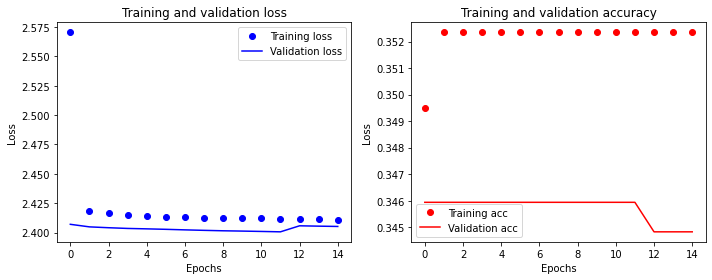

In [259]:
show_history_plot(rnn_history_10000)

- vocab size : 5000

In [105]:
rnn_history_5000 = train_with_tf_dataset(rnn_5000, 
                                          tf_dataset_5000_train, 
                                          tf_dataset_5000_test, 
                                          epochs=100)

Epoch 1/100
127/127 [==============================] - 29s 221ms/step - loss: 2.8571 - accuracy: 0.3222 - val_loss: 2.4347 - val_accuracy: 0.3415
Epoch 2/100
127/127 [==============================] - 28s 218ms/step - loss: 2.4281 - accuracy: 0.3520 - val_loss: 2.4293 - val_accuracy: 0.3415
Epoch 3/100
127/127 [==============================] - 28s 218ms/step - loss: 2.4259 - accuracy: 0.3520 - val_loss: 2.4258 - val_accuracy: 0.3415
Epoch 4/100
127/127 [==============================] - 28s 218ms/step - loss: 2.4242 - accuracy: 0.3520 - val_loss: 2.4232 - val_accuracy: 0.3415
Epoch 5/100
127/127 [==============================] - 28s 218ms/step - loss: 2.4230 - accuracy: 0.3520 - val_loss: 2.4214 - val_accuracy: 0.3415
Epoch 6/100
127/127 [==============================] - 28s 219ms/step - loss: 2.4223 - accuracy: 0.3520 - val_loss: 2.4203 - val_accuracy: 0.3415
Epoch 7/100
127/127 [==============================] - 28s 219ms/step - loss: 2.4213 - accuracy: 0.3520 - val_loss: 2.4195 -

#### 3) 모델 평가

- vocab size : 10000

In [296]:
rnn_acc_10000, rnn_f1_10000, predicted = evaluate(rnn_10000, X_test, dataset_10000.y_test)
rnn_acc_10000, rnn_f1_10000

(0.3619768477292965, 0.19240743851187844)

In [300]:
hist, bins = np.histogram(predicted, range(0, 47))
hist

array([   0,    0,    0, 2246,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

- vocab size : 5000

In [106]:
rnn_acc_5000, rnn_f1_5000, predicted = evaluate(rnn_5000, X_test, dataset_5000.y_test)
rnn_acc_5000, rnn_f1_5000

(0.3619768477292965, 0.19240743851187844)

In [107]:
hist, bins = np.histogram(predicted, range(0, 47))
hist

array([   0,    0,    0, 2246,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

두 경우 모두 너무 낮은 값이 나와 예측값을 확인해보니 모든 예측이 3으로 나왔다.<br>
모델 자체가 제대로 학습되지 않은 실패한 사례이다.

### 3. Simple Fully Connected

#### 1) 모델 정의

In [34]:
def get_FC(vocab_size):
    model = Sequential()
    model.add(Dense(1024, input_shape=(vocab_size,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(46, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

- vocab size : 10000

In [35]:
fc_100000 = get_FC(dataset_10000.X_train_tfidfv.shape[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              9903104   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 46)               

- vocab size : 5000

In [108]:
fc_50000 = get_FC(dataset_5000.X_train_tfidfv.shape[1])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1024)              4984832   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 46)               

#### 2) 모델 학습

In [36]:
def train_fc(model, dataset, batch_size=128, epochs=20):
    callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, mode='min', verbose=1)
    history = model.fit(x=dataset.X_train_tfidfv.toarray(),
                        y=dataset.y_train_ct, 
                        batch_size=batch_size, 
                        epochs=epochs,   
                        validation_split=0.1, 
                        use_multiprocessing=True,
                        workers=8, 
                        steps_per_epoch=None, 
                        callbacks=[callback])
    return history

- vocab size : 10000

In [37]:
fc_history_10000 = train_fc(fc_100000, dataset_10000, epochs=100)

Epoch 1/100
64/64 [==============================] - 1s 9ms/step - loss: 2.6498 - accuracy: 0.4030 - val_loss: 1.4358 - val_accuracy: 0.6808
Epoch 2/100
64/64 [==============================] - 0s 6ms/step - loss: 1.2306 - accuracy: 0.7132 - val_loss: 1.1470 - val_accuracy: 0.7397
Epoch 3/100
64/64 [==============================] - 0s 6ms/step - loss: 0.8075 - accuracy: 0.8058 - val_loss: 1.0520 - val_accuracy: 0.7697
Epoch 4/100
64/64 [==============================] - 0s 6ms/step - loss: 0.5665 - accuracy: 0.8538 - val_loss: 1.0655 - val_accuracy: 0.7742
Epoch 5/100
64/64 [==============================] - 0s 6ms/step - loss: 0.4230 - accuracy: 0.8916 - val_loss: 1.0556 - val_accuracy: 0.7887
Epoch 6/100
64/64 [==============================] - 0s 6ms/step - loss: 0.2933 - accuracy: 0.9263 - val_loss: 1.0200 - val_accuracy: 0.7987
Epoch 7/100
64/64 [==============================] - 0s 6ms/step - loss: 0.2450 - accuracy: 0.9387 - val_loss: 1.0913 - val_accuracy: 0.7942
Epoch 8/100
6

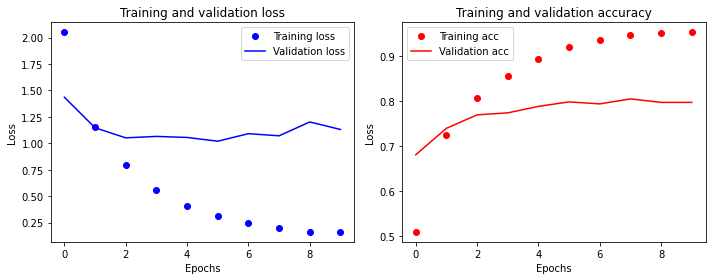

In [38]:
show_history_plot(fc_history_10000.history)

- vocab size : 5000

In [109]:
fc_history_5000 = train_fc(fc_50000, dataset_5000, epochs=100)

Epoch 1/100
64/64 [==============================] - 1s 7ms/step - loss: 2.6651 - accuracy: 0.3983 - val_loss: 1.4945 - val_accuracy: 0.6407
Epoch 2/100
64/64 [==============================] - 0s 5ms/step - loss: 1.3310 - accuracy: 0.6876 - val_loss: 1.1872 - val_accuracy: 0.7297
Epoch 3/100
64/64 [==============================] - 0s 5ms/step - loss: 0.9277 - accuracy: 0.7768 - val_loss: 1.0658 - val_accuracy: 0.7620
Epoch 4/100
64/64 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.8323 - val_loss: 1.0429 - val_accuracy: 0.7831
Epoch 5/100
64/64 [==============================] - 0s 5ms/step - loss: 0.4924 - accuracy: 0.8736 - val_loss: 1.0452 - val_accuracy: 0.7909
Epoch 6/100
64/64 [==============================] - 0s 5ms/step - loss: 0.4006 - accuracy: 0.8936 - val_loss: 1.0401 - val_accuracy: 0.7976
Epoch 7/100
64/64 [==============================] - 0s 4ms/step - loss: 0.2818 - accuracy: 0.9251 - val_loss: 1.0993 - val_accuracy: 0.8009
Epoch 8/100
6

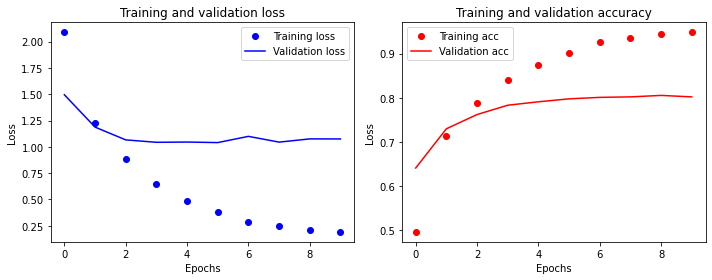

In [110]:
show_history_plot(fc_history_5000.history)

#### 3) 모델 평가

- vocab size : 10000

In [39]:
fc_acc_10000, fc_f1_10000, predicted = evaluate(fc_100000, dataset_10000.X_test_tfidfv.toarray(), dataset_10000.y_test)
fc_acc_10000, fc_f1_10000

(0.8081032947462155, 0.801556204587581)

In [40]:
hist, bins = np.histogram(predicted, range(0, 47))
hist

array([  9, 117,  14, 846, 502,   4,  13,   1,  43,  26,  28,  89,   6,
        32,   1,   3, 106,   5,  15, 139,  53,  31,   1,   9,  16,  30,
         8,   1,   8,   4,  12,   9,   8,   5,   3,   1,  18,   4,   2,
         3,   3,   5,   2,   6,   4,   1])

머신러닝에서 가장 점수가 높았던 voting과 비슷한 점수가 나왔다.

- vocab size : 5000

In [111]:
fc_acc_5000, fc_f1_5000, predicted = evaluate(fc_50000, dataset_5000.X_test_tfidfv.toarray(), dataset_5000.y_test)
fc_acc_5000, fc_f1_5000

(0.7960819234194123, 0.7918431124996802)

In [112]:
hist, bins = np.histogram(predicted, range(0, 47))
hist

array([  8, 120,  20, 812, 476,   3,  15,   2,  44,  27,  29, 106,   6,
        32,   1,   3, 120,   7,  16, 154,  49,  31,   3,  11,  25,  22,
         8,   1,  13,   7,   5,  13,   8,   4,   3,   1,   8,   2,   1,
         4,   4,   6,   3,   8,   4,   1])

vocab size가 10000일 때와 비슷한 수치가 나왔지만, 그것보다는 조금 낮았다.

## Step 5. 결론
---

### 프로젝트 평가

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가? <br>3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그 중 최적의 솔루션을 도출하였다.
    - 분류 모델을 통한 분류를 진행하였을 때, accuracy가 가장 높게 나온 것은 VotingClassifier이었다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가? <br>Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
    - 분류 모델을 통한 분류를 진행하였을 때, F1 score가 가장 높게 나온 것은 VotingClassifier이었다.
3. 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.
    - 머신러닝 모델에 사용된 데이터와 동일한 데이터를 학습/테스트 데이터로하여 총 세가지(1D CNN, LSTM, Fully Connected) 모델을 정의하여 실험을 진행하였다.
    -  하나의 Convolution Layer를 사용한 1D CNN 모델의 경우, accuracy가 37%, f1 score가 약25% 정도의 낮은 수치를 보였다. 이는 사용된 데이터가 TF-IDF 방식으로 인코딩된 즉 희소 표현으로 정의된 데이터이기 때문에, CNN을 통하여 학습을 진행하여도 학습이 제대로 이루어지지 않기 때문으로 추정된다. 희소 표현 정의된 데이터는 대부분이 0으로 구성되어 있고, 따라서 모델을 구성하는 Convolution 연산과 Max pooling 연산을 진행하여도 feature map의 값에 변화가 크게 없다. 그러한 이유로 얕은 층으로는 학습의 효과가 거의 없었을 것이라 생각된다. 그리고 데이터의 라벨이 한쪽으로 치우쳐져 있는데 이 밸런스를 조절하지 않았다는 점이 학습을 방해하는 요소가 되었을 것이라 생각한다.
    - 하나의 LSTM 레이어를 사용한 모델의 경우 1D CNN 보다 더 처첨한 결과를 보였다. 이 역시 희소 데이터의 특징에서 비롯된 것으로 추정된다. LSTM을 구성하는 게이트 중 하나인 망각 게이트는 현 시점의 정보와 은닉층의 값에 각각 가중치를 곱하여 더한 후 sigmoid를 취하는 동작을 하는데 이때, sigmoid의 결과 값이 0에 가까울 수록 정보를 많이 잃게 된다. 희소 표현으로 정의된 데이터 덕에 '현 시점의 정보'의 대부분은 0이 되고, 이는 과거의 데이터를 망각할 확률이 더 클 수 있음을 시사한다. 즉, 데이터 연산이 진행될 수록 이전의 데이터가 소실되었을 가능성이 존재하고 이는 학습을 방해하는 거대한 걸림돌이 되었을 것이다.
    - 가장 좋은 성능을 보인 모델은 3개의 Dense Layer를 쌓아 많은 신경망 모델이었다. 머신러닝과 마찬가지로 입력된 모든 데이터를 소실없이 모두 사용하였기 때문에 학습이 목표하는바와 유사하게 진행되지 않았나, 생각해본다.

### 회고

- going deeper로 넘어오면서 모델을 작성하는 부분에서 자유도가 조금 생긴 느낌이다. 다양한 시도를 하면서 할 수 있는 것들이 늘어가는 느낌이라 아주 보람차다.
- 희소표현이 딥러닝 모델의 입력으로 부적절한 이유에 대해서 여러가지 자료를 보고 생각을하여 평가를 작성하였지만, 정답이 아닌 것 같아 마음이 불편한다. 어딘가에 저 문제에 대한 답이 있을 것 같은데 아직 찾지를 못하였고 이 점 때문에 프로젝트의 완성도가 너무 낮아진 느낌이다. 다음에는 자료를 찾는 부분에 좀 더 시간을 들여야 겠다.

## ref
---
- [CNN으로 문장 분류하기](https://ratsgo.github.io/natural%20language%20processing/2017/03/19/CNN/)
- [[Python/Jupyter] TF-IDF 파라미터 알아보기 / min_idf, analyzer, sublinear_tf, ngram_range, max_features](https://chan-lab.tistory.com/27)
 - [자연어 처리를 위한 1D CNN(1D Convolutional Neural Networks)](https://wikidocs.net/80437)
 - [How to Choose Loss Functions When Training Deep Learning Neural Networks](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
 - [Are deep learning models suitable for training with sparse data?](https://towardsdatascience.com/why-deep-learning-is-needed-over-traditional-machine-learning-1b6a99177063)
 - [Long Short-Term Memory(LSTM)](https://yjjo.tistory.com/17)
 - [5.3 분류모형](https://datascienceschool.net/03%20machine%20learning/09.03%20%EB%B6%84%EB%A5%98%EB%AA%A8%ED%98%95.html)
 - [5.4 분류 성능평가](https://datascienceschool.net/03%20machine%20learning/09.04%20%EB%B6%84%EB%A5%98%20%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80.html)
 - [6.6 베이즈 정리](https://datascienceschool.net/02%20mathematics/06.06%20%EB%B2%A0%EC%9D%B4%EC%A6%88%20%EC%A0%95%EB%A6%AC.html)